In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt

data_in = "/Users/vigadam/Dropbox/github/media_network/media_data/media-parliament-scaling/data/input/"
data_out = "/Users/vigadam/Dropbox/github/media_network/media_data/media-parliament-scaling/data/output/"
warnings.filterwarnings("ignore")

In [2]:
pd.read_csv(data_in + "parlament_speech_2020.csv").iloc[0:3, 0:4].assign(
    text=lambda x: x["text_strip"].str[0:30] + "...",
    type=lambda x: x["type"].str[0:30] + "...",
).drop(columns=["text_strip"])

,speaker,speaker_party,type,text
0,Kövér László,Fidesz,Az ülésnap megnyitása...,Tisztelt Országgyűlés! Az Orsz...
1,Szabó Timea,Párbeszéd,napirend előttihez hozzászólás...,Tisztelt Miniszter Úr! Az ön n...
2,Dr. Harangozó Tamás,MSZP,azonnali kérdésre adott képvis...,"Köszönöm a szót, elnök úr. Err..."


## create observed ideology yc

In [3]:
parldata = pd.read_csv(data_in + "parlament_speech_2020.csv")
votedata = pd.read_csv(data_in + "vote_outcomes_2018.csv",index_col = False)

In [4]:
votedata = (
    votedata.merge(
        votedata.loc[
            lambda x: x["Jelölő szervezet(ek)"] == "FIDESZ-KDNP", ["%", "const"]
        ].rename(columns={"%": "ideology"}),
        how="left",
        on="const",
    )
    .loc[lambda x: x["Mandátum"] == "Igen"]
    .sort_values(by=["ideology"])
    .rename(columns={"Jelölt neve": "name"})
)

In [5]:
votedata["name"] = votedata["name"].str.replace("Dr. ","")
parldata["speaker"] = parldata["speaker"].str.replace("Dr. ","")
votedata["name"] = votedata["name"].str.replace("V.Németh Zsolt","Németh Zsolt")
votedata["name"] = votedata["name"].str.replace("Vécsey László József","Vécsey László")
votedata["name"] = votedata["name"].str.replace("B Nagy László","B. Nagy László")

In [6]:
yc = (
    parldata.filter(["speaker", "oldal"])
    .rename(columns={"speaker": "name"})
    .merge(votedata.filter(["name", "ideology"]), how="left", on="name")
    .drop_duplicates("name")
)

In [7]:
yc.dropna(subset = ["ideology"]).to_csv(data_out + "yc_origin.csv")

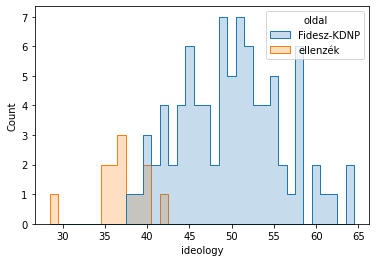

In [8]:
sns.histplot(x="ideology", data=yc, hue="oldal", binwidth=1, element="step")

plt.savefig("/".join(data_out.split("/")[:-3]) + "/figures/observed_ideology.png")
plt.show()

In [9]:
yc.loc[lambda x: x["oldal"] == "Fidesz-KDNP", "ideology"] = yc.loc[
    lambda x: x["oldal"] == "Fidesz-KDNP", "ideology"
].fillna(yc.groupby("oldal")["ideology"].mean()["Fidesz-KDNP"])

yc.loc[lambda x: x["oldal"] == "ellenzék", "ideology"] = yc.loc[
    lambda x: x["oldal"] == "ellenzék", "ideology"
].fillna(yc.groupby("oldal")["ideology"].mean()["ellenzék"])

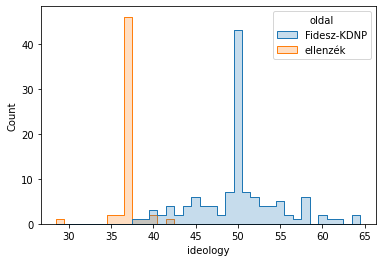

In [10]:
sns.histplot(x="ideology", data=yc, hue="oldal", binwidth=1, element="step")
plt.savefig("/".join(data_out.split("/")[:-3]) + "/figures/observed_ideology_imputed.png")
plt.show()

In [11]:
yc.to_csv(data_out + "yc.csv")

## Calculate  intercept and slope for all phrases

In [12]:
freq = pd.read_csv(data_out + "frequency_of_phrases_parliament.csv")
yc = pd.read_csv(data_out + "yc.csv")
#yc = pd.read_csv(data_out + "yc_origin.csv")

freq = freq.merge(
    yc.filter(["name", "ideology"]), how="left", left_on="doc_id", right_on="name"
).drop(columns=["doc_id"])

#freq = freq.dropna(subset=["ideology"]).reset_index(drop=True)

In [13]:
names = freq["name"]
yc = freq["ideology"]
Phases = freq.iloc[:, :-2].div(freq.sum(axis=1), axis=0)

In [14]:
p_a_b = pd.DataFrame(Phases.columns.tolist(), columns=["p"]).assign(a=None, b=None)

from sklearn import preprocessing

df = pd.concat([Phases,yc],axis=1)

colnames = df.columns
 Create the Scaler object
scaler = preprocessing.StandardScaler()
 Fit your data on the scaler object
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=colnames)

yc = scaled_df["ideology"]
Phases_scaled = scaled_df.iloc[:,:-1]

In [15]:
# estimate intercept and slope parameters for every phrase
for i in range(0, p_a_b.shape[0]):
    X = yc
    X = sm.add_constant(X)
    fc = Phases.iloc[:, i]

    model = sm.OLS(fc, X)
    results = model.fit()
    p_a_b.loc[i, "a"] = results.params[0]
    p_a_b.loc[i, "b"] = results.params[1]

<AxesSubplot:>

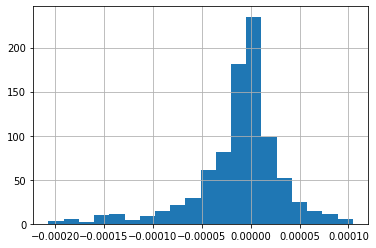

In [16]:
# slope
p_a_b["b"].sort_values().iloc[20:-10].hist(bins=20)

<AxesSubplot:>

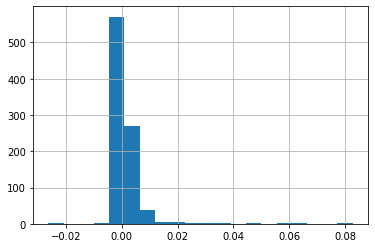

In [17]:
# intercept
p_a_b["a"].hist(bins=20)

In [18]:
p_a_b.to_csv(data_out + "phrase_intercept_slope.csv")

##  in-sample evidence

In [19]:
freq = pd.read_csv(data_out + "frequency_of_phrases_parliament.csv")
yc = pd.read_csv(data_out + "yc.csv")
#yc = pd.read_csv(data_out + "yc_origin.csv")
p_a_b = pd.read_csv(data_out + "phrase_intercept_slope.csv",index_col = 0)

freq = freq.merge(
    yc.filter(["name", "ideology"]), how="left", left_on="doc_id", right_on="name"
).drop(columns=["doc_id"])
#freq = freq.dropna(subset=["ideology"]).reset_index(drop=True)

In [20]:
def predict_y_hat(freq, p_a_b):
    if "ideology" in freq.columns.tolist():
        Phases = freq.drop(columns=["name", "ideology"]).div(freq.sum(axis=1), axis=0)
    elif "name" in freq.columns.tolist():
        Phases = freq.drop(columns=["name"]).div(freq.sum(axis=1), axis=0)
    else:
        print("You should always have a 'name' columns in freq table")

    for i in range(Phases.shape[0]):

        out = (
            Phases.iloc[i, :]
            .T.rename("fpn")
            .reset_index()
            .merge(p_a_b, left_on="index", right_on="p")
            .drop(columns=["index"])
            .assign(
                f_minus_a_times_b=lambda x: (x["fpn"] - x["a"]) * x["b"],
                b_squared=lambda x: x["b"] * x["b"],
            )
            .sum(axis=0)
            .filter(["f_minus_a_times_b", "b_squared"])
        )

        freq.loc[i, "y_hat"] = out["f_minus_a_times_b"] / out["b_squared"]

    if "ideology" in freq.columns.tolist():
        prediction_table = freq.filter(
            ["name", "ideology", "y_hat", "y_hat_abs"]
        ).sort_values(by=["y_hat"])
    else:
        prediction_table = freq.filter(["name", "y_hat", "y_hat_abs"]).sort_values(
            by=["y_hat"]
        )

    return prediction_table.reset_index(drop=True)

In [21]:
insample_pred = predict_y_hat(freq, p_a_b)

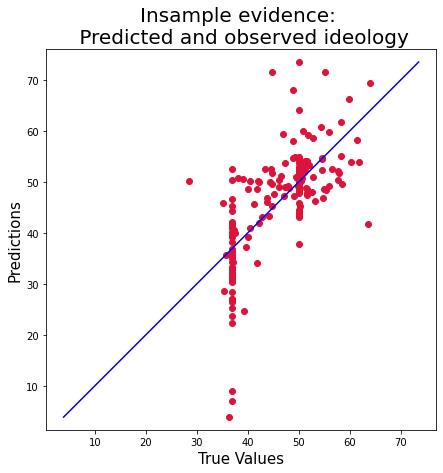

In [22]:
plt.figure(figsize=(7, 7))
true_value = insample_pred["ideology"]
predicted_value = insample_pred["y_hat"]

plt.scatter(true_value, predicted_value, c="crimson")

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], "b-")
plt.xlabel("True Values", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.axis("equal")
plt.title("Insample evidence: \n Predicted and observed ideology",fontsize = 20)
plt.savefig("/".join(data_out.split("/")[:-3]) + "/figures/insample_evidence_rep.png")
plt.show()

In [23]:
insample_pred[["ideology", "y_hat"]].corr()

,ideology,y_hat
ideology,1.000000,0.678075
y_hat,0.678075,1.000000


## predict on representatives with nonobserved ideology

In [24]:
freq = pd.read_csv(data_out + "frequency_of_phrases_parliament.csv")
#yc = pd.read_csv(data_out + "yc.csv")
yc = pd.read_csv(data_out + "yc_origin.csv")
p_a_b = pd.read_csv(data_out + "phrase_intercept_slope.csv",index_col = 0)

freq = freq.merge(
    yc.filter(["name", "ideology"]), how="left", left_on="doc_id", right_on="name"
).drop(columns=["name"]).rename(columns={"doc_id":"name"})

freq = freq.loc[lambda x: x["ideology"].isnull()].reset_index(drop=True)

In [25]:
prediction_on_nonobserved_representatives = predict_y_hat(freq, p_a_b)

In [26]:
parldata = pd.read_csv(data_in + "parlament_speech_2020.csv").assign(
    name=lambda x: x["speaker"].str.replace("Dr. ", "")
)
prediction_on_nonobserved_representatives = (
    prediction_on_nonobserved_representatives.merge(
        parldata[["name", "oldal"]], on="name"
    )
    .drop(columns=["ideology"])
    .drop_duplicates()
)

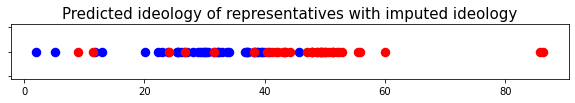

In [27]:
fig, ax = plt.subplots(figsize=(10, 1))
ax.plot(
    prediction_on_nonobserved_representatives.loc[
        lambda x: x["oldal"] == "ellenzék", "y_hat"
    ],
    np.zeros_like(
        prediction_on_nonobserved_representatives.loc[
            lambda x: x["oldal"] == "ellenzék", "y_hat"
        ]
    ),
    ".",
    markersize=15,
    markeredgewidth=2,
    markeredgecolor="blue",
    markerfacecolor="blue",
)

ax.plot(
    prediction_on_nonobserved_representatives.loc[
        lambda x: x["oldal"] == "Fidesz-KDNP", "y_hat"
    ],
    np.zeros_like(
        prediction_on_nonobserved_representatives.loc[
            lambda x: x["oldal"] == "Fidesz-KDNP", "y_hat"
        ]
    ),
    ".",
    markersize=15,
    markeredgewidth=2,
    markeredgecolor="r",
    markerfacecolor="r",
)
ax.set_yticklabels([])

plt.title("Predicted ideology of representatives with imputed ideology",fontsize=15)

plt.savefig("/".join(data_out.split("/")[:-3]) + "/figures/GS-scaling-representatives.png")
plt.show()

Now, merge with representatives with observed ideology and save for model 2

In [28]:
yc = pd.read_csv(data_out + "yc_origin.csv")

In [29]:
pd.concat(
    [
        yc.iloc[:, 1:],
        prediction_on_nonobserved_representatives.rename(columns={"y_hat": "ideology"}),
    ]
).reset_index(drop=True).to_csv(data_out + "yc_pred.csv")

## prediction on media

In [62]:
freq = pd.read_csv(data_out + "frequency_of_phrases_media.csv").rename(
    columns={"doc_id": "name"}
)
p_a_b = pd.read_csv(data_out + "phrase_intercept_slope.csv")
yc = pd.read_csv(data_out + "yc.csv")

In [63]:
pred = predict_y_hat(freq, p_a_b)

pred["name"] = pred["name"].map(
    {
        "mno": "MNO",
        "888": "888.hu",
        "origo": "Origo",
        "Index": "Index\n",
        "444": "444.hu",
        "24.hu": "24.hu",
    }
)
pred = pred.append(
    yc.groupby("oldal")["ideology"]
    .mean()
    .to_frame()
    .reset_index()
    .rename(columns={"oldal": "name", "ideology": "y_hat"}),
    ignore_index=True,
)

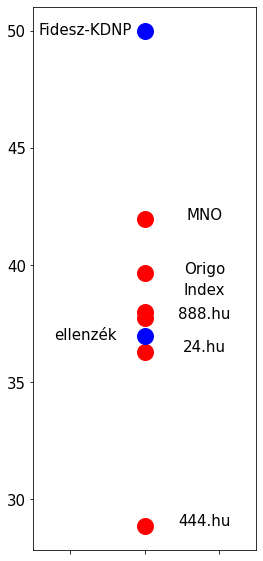

In [64]:
fig, ax = plt.subplots(figsize=(4, 10))
ax.plot(
    np.zeros_like(pred["y_hat"].iloc[:6]),
    pred["y_hat"].iloc[:6],
    "o",
    markersize=15,
    markeredgewidth=2,
    markeredgecolor="r",
    markerfacecolor="r",
)

ax.plot(
    np.zeros_like(pred["y_hat"].iloc[6:]),
    pred["y_hat"].iloc[6:],
    "o",
    markersize=15,
    markeredgewidth=2,
    markeredgecolor="b",
    markerfacecolor="b",
)
plt.xlim([-3,3])
ax.set_xticklabels([])
ax.tick_params(labelsize=15)

for i, txt in enumerate(pred["name"].iloc[:6]):
    ax.annotate(
        txt,
        (np.zeros_like(pred["y_hat"])[i], pred["y_hat"][i]),
        xytext=(np.zeros_like(pred["y_hat"])[i] + 1.6, pred["y_hat"][i]),
        ha="center",
        size=15,
    )

ax.annotate(
    pred["name"][6],
    (np.zeros_like(pred["y_hat"])[6], pred["y_hat"][6]),
    xytext=(np.zeros_like(pred["y_hat"])[6] -1.6 , pred["y_hat"][6]-0.15),
    ha="center",
    size=15,
)

ax.annotate(
    pred["name"][7],
    (np.zeros_like(pred["y_hat"])[7], pred["y_hat"][7]),
    xytext=(np.zeros_like(pred["y_hat"])[7] - 1.6, pred["y_hat"][7]-0.15),
    ha="center",
    size=15
)

# plt.title("Predicted ideology of media outlets, and reference scores of the two sides",fontsize = 15)

plt.savefig("/".join(data_out.split("/")[:-3]) + "/figures/GS-scaling-media.png")
plt.show()

fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(
    pred["y_hat"].iloc[:6],
    np.zeros_like(pred["y_hat"].iloc[:6]),
    ".",
    markersize=15,
    markeredgewidth=2,
    markeredgecolor="r",
    markerfacecolor="r",
)

ax.plot(
    pred["y_hat"].iloc[6:],
    np.zeros_like(pred["y_hat"].iloc[6:]),
    ".",
    markersize=15,
    markeredgewidth=2,
    markeredgecolor="b",
    markerfacecolor="b",
)
plt.xlim()
ax.set_yticklabels([])

for i, txt in enumerate(pred["name"].iloc[:6]):
    ax.annotate(
        txt,
        (pred["y_hat"][i], np.zeros_like(pred["y_hat"])[i]),
        xytext=(pred["y_hat"][i], np.zeros_like(pred["y_hat"])[i] + 0.01),
        ha="center",
    )

ax.annotate(
    pred["name"][6],
    (pred["y_hat"][6], np.zeros_like(pred["y_hat"])[6]),
    xytext=(pred["y_hat"][6], np.zeros_like(pred["y_hat"])[6] - 0.02),
    ha="center",
)

ax.annotate(
    pred["name"][7],
    (pred["y_hat"][7], np.zeros_like(pred["y_hat"])[7]),
    xytext=(pred["y_hat"][7], np.zeros_like(pred["y_hat"])[7] - 0.02),
    ha="center",
)

#plt.title("Predicted ideology of media outlets, and reference scores of the two sides",fontsize = 15)

plt.savefig("/".join(data_out.split("/")[:-3]) + "/figures/GS-scaling-media.png")
plt.show()

In [59]:
pred = predict_y_hat(freq, p_a_b)

pred["name"] = pred["name"].map(
    {
        "mno": "Magyar Nemzet",
        "888": "888.hu",
        "origo": "Origo",
        "Index": "Index",
        "444": "444.hu",
        "24.hu": "24.hu",
    }
)

pred = (
    pred.append(
        yc.groupby("oldal")["ideology"]
        .mean()
        .to_frame()
        .reset_index()
        .rename(columns={"oldal": "name", "ideology": "y_hat"}),
        ignore_index=True,
    )
    .sort_values(by=["y_hat"],ascending=False)
    .round(2)
    .rename(columns={"y_hat": "predicted ideology"})
    .set_index("name")
)

In [60]:
pred

,predicted ideology
name,
Fidesz-KDNP,49.97
Magyar Nemzet,41.96
Origo,39.67
Index,38.03
888.hu,37.77
ellenzék,36.97
24.hu,36.33
444.hu,29.01


In [61]:
pred.to_latex("GS-media-pred.tex")

## Now create a new model, with predicted and observed ideology on representatives

### Create intercept and slope

In [36]:
freq = pd.read_csv(data_out + "frequency_of_phrases_parliament.csv")
yc = pd.read_csv(data_out + "yc_pred.csv")
#yc = pd.read_csv(data_out + "yc_origin.csv")

freq = freq.merge(
    yc.filter(["name", "ideology"]), how="left", left_on="doc_id", right_on="name"
).drop(columns=["doc_id"])

#freq = freq.dropna(subset=["ideology"]).reset_index(drop=True)

In [37]:
names = freq["name"]
yc = freq["ideology"]
Phases = freq.iloc[:, :-2].div(freq.sum(axis=1), axis=0)

In [38]:
p_a_b = pd.DataFrame(Phases.columns.tolist(), columns=["p"]).assign(a=None, b=None)

In [39]:
# estimate intercept and slope parameters for every phrases
for i in range(0, p_a_b.shape[0]):
    X = yc
    X = sm.add_constant(X)
    fc = Phases.iloc[:, i]

    model = sm.OLS(fc, X)
    results = model.fit()
    p_a_b.loc[i, "a"] = results.params[0]
    p_a_b.loc[i, "b"] = results.params[1]

<AxesSubplot:>

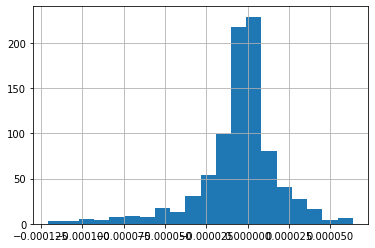

In [40]:
# slope
p_a_b["b"].sort_values().iloc[20:-10].hist(bins=20)

<AxesSubplot:>

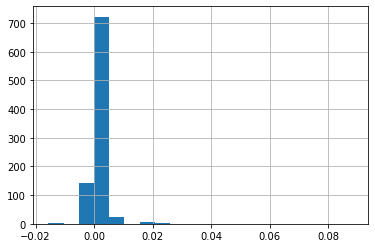

In [41]:
# intercept
p_a_b["a"].hist(bins=20)

In [42]:
p_a_b.to_csv(data_out + "phrase_intercept_slope_v2.csv")

### check insample evidence

In [43]:
freq = pd.read_csv(data_out + "frequency_of_phrases_parliament.csv")
yc = pd.read_csv(data_out + "yc_pred.csv")
p_a_b = pd.read_csv(data_out + "phrase_intercept_slope_v2.csv",index_col = 0)

freq = freq.merge(
    yc.filter(["name", "ideology"]), how="left", left_on="doc_id", right_on="name"
).drop(columns=["doc_id"])

In [44]:
insample_pred = predict_y_hat(freq, p_a_b)

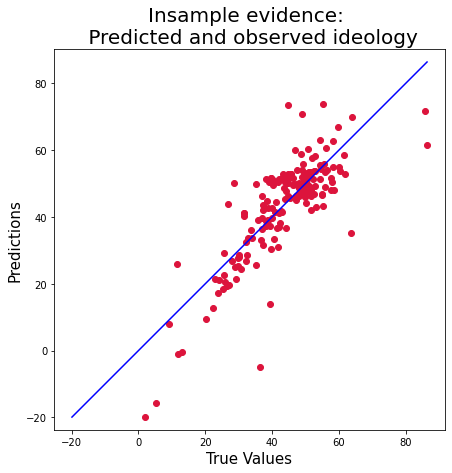

In [45]:
plt.figure(figsize=(7, 7))
true_value = insample_pred["ideology"]
predicted_value = insample_pred["y_hat"]

plt.scatter(true_value, predicted_value, c="crimson")

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], "b-")
plt.xlabel("True Values", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.axis("equal")
plt.title("Insample evidence: \n Predicted and observed ideology",fontsize = 20)
plt.savefig("/".join(data_out.split("/")[:-3]) + "/figures/insample_evidence_rep_v2.png")
plt.show()

### prediction on media with the new model

In [46]:
freq = pd.read_csv(data_out + "frequency_of_phrases_media.csv").rename(
    columns={"doc_id": "name"}
)
p_a_b = pd.read_csv(data_out + "phrase_intercept_slope_v2.csv")

# BUT compare to original
yc = pd.read_csv(data_out + "yc.csv",index_col=0)

# not origal
yc = pd.read_csv(data_out + "yc_pred.csv",index_col=0)

In [47]:
pred = predict_y_hat(freq, p_a_b)

pred["name"] = pred["name"].map(
    {
        "mno": "MNO",
        "888": "888.hu",
        "origo": "Origo",
        "Index": "Index",
        "444": "444.hu",
        "24.hu": "24.hu",
    }
)
pred = pred.append(
    yc.groupby("oldal")["ideology"]
    .mean()
    .to_frame()
    .reset_index()
    .rename(columns={"oldal": "name", "ideology": "y_hat"}),
    ignore_index=True,
)

In [48]:
pred

,name,y_hat
0,444.hu,27.029026
1,24.hu,35.336809
2,888.hu,36.200165
3,Index,36.747526
4,Origo,38.189742
5,MNO,40.786317
6,Fidesz-KDNP,49.001079
7,ellenzék,31.677293


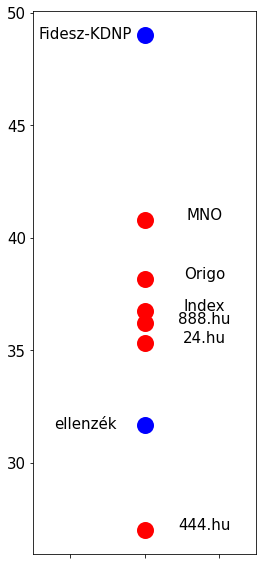

In [49]:
fig, ax = plt.subplots(figsize=(4, 10))
ax.plot(
    np.zeros_like(pred["y_hat"].iloc[:6]),
    pred["y_hat"].iloc[:6],
    "o",
    markersize=15,
    markeredgewidth=2,
    markeredgecolor="r",
    markerfacecolor="r",
)

ax.plot(
    np.zeros_like(pred["y_hat"].iloc[6:]),
    pred["y_hat"].iloc[6:],
    "o",
    markersize=15,
    markeredgewidth=2,
    markeredgecolor="b",
    markerfacecolor="b",
)
plt.xlim([-3,3])
ax.set_xticklabels([])
ax.tick_params(labelsize=15)

for i, txt in enumerate(pred["name"].iloc[:6]):
    ax.annotate(
        txt,
        (np.zeros_like(pred["y_hat"])[i], pred["y_hat"][i]),
        xytext=(np.zeros_like(pred["y_hat"])[i] + 1.6, pred["y_hat"][i]),
        ha="center",
        size=15,
    )

ax.annotate(
    pred["name"][6],
    (np.zeros_like(pred["y_hat"])[6], pred["y_hat"][6]),
    xytext=(np.zeros_like(pred["y_hat"])[6] -1.6 , pred["y_hat"][6]-0.15),
    ha="center",
    size=15,
)

ax.annotate(
    pred["name"][7],
    (np.zeros_like(pred["y_hat"])[7], pred["y_hat"][7]),
    xytext=(np.zeros_like(pred["y_hat"])[7] - 1.6, pred["y_hat"][7]-0.15),
    ha="center",
    size=15
)

# plt.title("Predicted ideology of media outlets, and reference scores of the two sides",fontsize = 15)

plt.savefig("/".join(data_out.split("/")[:-3]) + "/figures/GS-scaling-media-v2.png")
plt.show()